# Kalman Filter

Imagine a robot. Robot state is described with the following parameters

1. $x$, $y$ - robot coordinates,
2. $V_x$, $V_y$ - velocities.

We can only measure the coordinates of the robot, which should be reflected in the $ H $ matrix.

- Fill in the matrices for the Kalman filter correctly.
- For all three experiments, visualize the dependence of $ x $, $ y $, $ V_x $, $ V_y $ over time.
- For all three experiments, visualize the dependence of each component of the gain matrix ($ K $) over time.
     - What does the dynamics of changes in its components say?
- How much does the velocity uncertainty decrease as a result of each experiment?

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

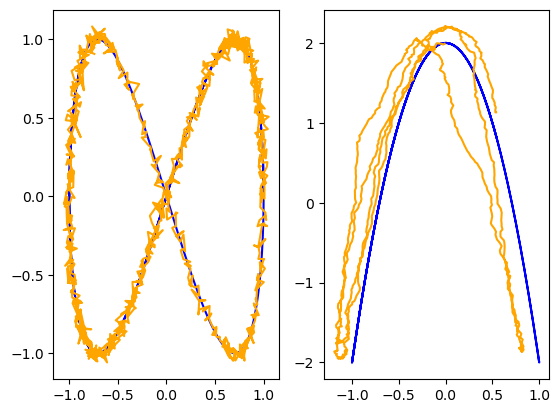

In [2]:
t = np.linspace(0, 10, 1001)

x_real = np.array([
    np.cos(t), 
    np.sin(2*t),
    -np.sin(t),
    np.cos(2*t) * 2
]).T

x_start = x_real[0]

measure_cov = np.eye(2) * 1e-3
measured_noise = multivariate_normal.rvs(mean=[0, 0], cov=measure_cov, size=len(t))
measurements = x_real[:, :2] + measured_noise

control_cov = np.eye(2) * 1e-4
control_noise = multivariate_normal.rvs(mean=[0, 0], cov=control_cov, size=len(t))
control = np.zeros((x_real.shape[0], 2))
control[:-1] = x_real[1:, -2:] - x_real[:-1, -2:]
control[:, -2:] += control_noise

ctrl_velocity = np.cumsum(control[:, -2:], axis=0) + x_real[0, -2:]

fig, ax = plt.subplots(1, 2)

ax[0].plot(x_real[:, 0], x_real[:, 1], 'b')
ax[1].plot(x_real[:, 2], x_real[:, 3], 'b')

ax[0].plot(measurements[:, 0], measurements[:, 1], color='orange')
ax[1].plot(ctrl_velocity[:, 0], ctrl_velocity[:, 1], color='orange')


In [3]:
def filter(x, z, u, E, F, B, Q, H, R):
    x_history = []
    E_history = []
    
    x = x.reshape(-1, 1)
    
    for i in range(z.shape[0]):
        # prediction
        x = (F @ x) + B @ u[i].reshape(-1, 1)
        E = F @ E @ F.T + Q

        # measurement update
        K = E @ H.T @ np.linalg.inv(H @ E @ H.T + R)
        x = x + K @ (z[i].reshape(-1, 1) - H @ x)
        E = E - K @ H @ E

        x_history.append(x)
        E_history.append(E)
        
    x_history = np.array(x_history).squeeze()
    E_history = np.array(E_history).squeeze()
        
    return x_history, E_history

In [4]:
dt = t[1] - t[0]

# initial covariance matrix: 0. for positions x and y, 1000 for the two velocities

E = np.eye(4) * 0.1

# next state function: 4D
F = np.array([
    [1, 0, dt, 0],
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

B = np.array([
    [0, 0],
    [0, 0],
    [1, 0],
    [0, 1]
])

Q = np.eye(4) * 1e-2

# measurement function: reflect the fact that we observe x and y but not the two velocities
H = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

# measurement uncertainty: use 2x2 matrix with 0.1 as main diagonal
R = np.eye(2) * 1

In [5]:
x_history, E_history = filter(x=x_start, z=measurements, u=control, E=E, F=F, B=B, Q=Q, H=H, R=R)

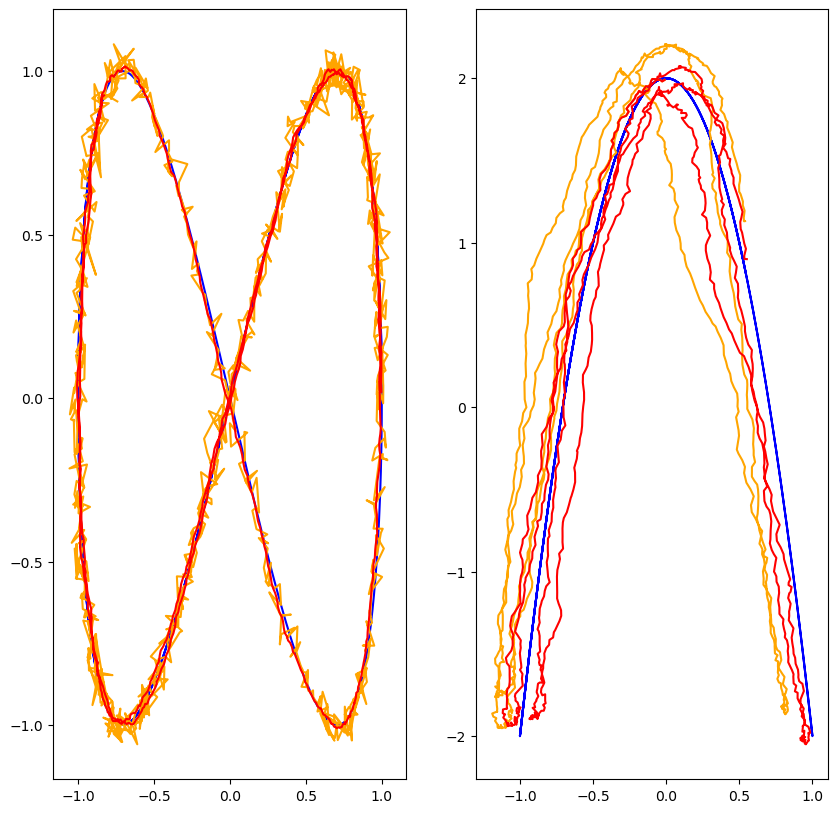

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].plot(x_real[:, 0], x_real[:, 1], 'b')
ax[1].plot(x_real[:, 2], x_real[:, 3], 'b')

ax[0].plot(measurements[:, 0], measurements[:, 1], color='orange')
ax[1].plot(ctrl_velocity[:, 0], ctrl_velocity[:, 1], color='orange')


ax[0].plot(x_history[:, 0], x_history[:, 1], color='red')
ax[1].plot(x_history[:, 2], x_history[:, 3], color='red')

plt.show()